In [1]:
import pandas as pd
import numpy as np
import os
import sys
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

import gc

warnings.filterwarnings('ignore', category=UserWarning)

sys.path.append(os.path.abspath("../.."))

from utils.scatter_plot import scatter_prediction
from utils.eval_call import evaluate_model

from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer
from Preprocessing.preprocessing_pipeline_impute import preprocessing_pipeline
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.split import split_data


In [2]:
class SemanticCategoricalEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_dim=5, embedding_method='target_guided'):
        self.embedding_dim = embedding_dim
        self.embedding_method = embedding_method
        self.embeddings = {}
        self.category_stats = {}
        self.feature_names = None
        
    def fit(self, X, y=None):
        self.feature_names = X.columns.tolist() if hasattr(X, 'columns') else None
        
        X_array = np.asarray(X)
        
        for col_idx in range(X_array.shape[1]):
            feature_name = self.feature_names[col_idx] if self.feature_names else col_idx
            unique_values = np.unique(X_array[:, col_idx])
            
            self.embeddings[col_idx] = {}
            self.category_stats[col_idx] = {}
            
            if self.embedding_method == 'random':
                for value in unique_values:
                    self.embeddings[col_idx][value] = np.random.normal(0, 1, self.embedding_dim)
            
            elif self.embedding_method == 'target_guided' and y is not None:
                for value in unique_values:
                    value_mask = X_array[:, col_idx] == value
                    if np.sum(value_mask) > 0:
                        target_mean = np.mean(y[value_mask])
                        target_std = np.std(y[value_mask]) if np.sum(value_mask) > 1 else 1.0
                        count = np.sum(value_mask)
                        
                        self.category_stats[col_idx][value] = {
                            'mean': target_mean,
                            'std': target_std,
                            'count': count
                        }
                        
                        embedding = np.zeros(self.embedding_dim)
                        embedding[0] = target_mean / 100000.0
                        embedding[1] = np.log1p(count) / 10.0
                        embedding[2] = target_std / 50000.0
                        
                        if self.embedding_dim > 3:
                            embedding[3:] = np.random.normal(0, 0.1, self.embedding_dim - 3)
                            
                        self.embeddings[col_idx][value] = embedding
                    else:
                        self.embeddings[col_idx][value] = np.zeros(self.embedding_dim)
            
            elif self.embedding_method == 'frequency':
                value_counts = {val: np.sum(X_array[:, col_idx] == val) for val in unique_values}
                total_count = sum(value_counts.values())
                
                for value in unique_values:
                    frequency = value_counts[value] / total_count if total_count > 0 else 0
                    embedding = np.zeros(self.embedding_dim)
                    embedding[0] = frequency
                    if self.embedding_dim > 1:
                        embedding[1:] = np.random.normal(0, frequency, self.embedding_dim - 1)
                    self.embeddings[col_idx][value] = embedding
            
            else:
                for value in unique_values:
                    self.embeddings[col_idx][value] = np.random.normal(0, 1, self.embedding_dim)
        
        return self
        
    def transform(self, X):
        X_array = np.asarray(X)
        result = np.zeros((X_array.shape[0], X_array.shape[1] * self.embedding_dim))
        
        for col_idx in range(X_array.shape[1]):
            for row_idx in range(X_array.shape[0]):
                value = X_array[row_idx, col_idx]
                if value in self.embeddings[col_idx]:
                    embedding = self.embeddings[col_idx][value]
                else:
                    embedding = np.zeros(self.embedding_dim)
                
                start_idx = col_idx * self.embedding_dim
                end_idx = start_idx + self.embedding_dim
                result[row_idx, start_idx:end_idx] = embedding
                
        return result

In [3]:
df = preprocessing_pipeline('../../data.csv')

X_train, X_test, y_train, y_test, X, y, categorical_features, numeric_features = split_data(df)


In [6]:
# Define embedding parameters
embedding_dim = 8
embedding_method = 'target_guided'

In [7]:
# Set up transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Use semantic embeddings for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('embedder', SemanticCategoricalEmbedder(embedding_dim=embedding_dim, embedding_method=embedding_method))
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Set number of CPU cores to use
n_jobs = min(4, max(1, os.cpu_count() or 2))  # Limit to max 4 threads

# Create the KNN pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(
        n_neighbors=4,
        weights='distance',  
        algorithm='auto',
        p=2,  # Euclidean distance
        n_jobs=n_jobs
    ))
])


Training KNN model with semantic embeddings...
Making predictions...
Making predictions...


c:\Users\kilia\Desktop\MA_Master\Vorlesung_S5\DataMining\proj\proj\.venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\kilia\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\kilia\Desktop\MA_Master\Vorlesung_S5\DataMining\proj\proj\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\kilia\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\kilia\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1599, in _readerthread
    


Model Evaluation:
KNN with Semantic Embeddings Performance Metrics:
MAE: 3481.80
MSE: 94268030.59
RMSE: 9709.17
R²: 0.91
------------------------------

Generating visualization...


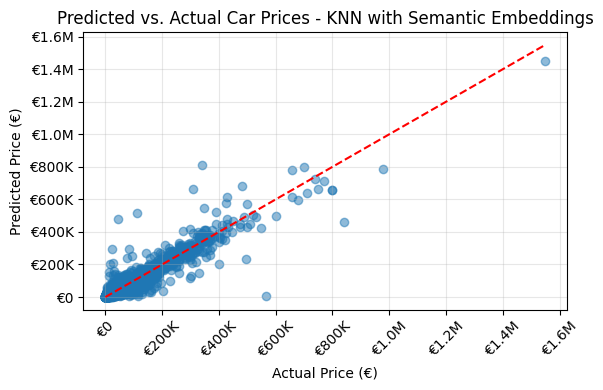

Memory cleaned up.


In [8]:
# Train and evaluate the model
try:
    print("\nTraining KNN model with semantic embeddings...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        knn_pipeline.fit(X_train, y_train)
    
    print("Making predictions...")
    y_pred_knn = knn_pipeline.predict(X_test)
    
    print("\nModel Evaluation:")
    metrics = evaluate_model(y_test, y_pred_knn, "KNN with Semantic Embeddings")
    
    print("\nGenerating visualization...")
    scatter_prediction(y_test, y_pred_knn, "KNN with Semantic Embeddings")
    
except Exception as e:
    print(f"Error during model training or evaluation: {str(e)}")
finally:
    # Clean up memory
    gc.collect()
    print("Memory cleaned up.")